In [1]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import tqdm as tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy
import wandb
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
# Initialize Weights & Biases
wandb.init(project="visiontransformer")

C:\Users\offic\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Currently logged in as: abdulvahapmutlu (abdulvahapmutlu-firat). Use `wandb login --relogin` to force relogin


In [2]:
# Data Augmentation and Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
dataset = datasets.ImageFolder(root=r'C:\Users\offic\OneDrive\Masaüstü\datasets\EuroSAT', transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Mixup Augmentation
mixup = Mixup(mixup_alpha=0.2)  # Adjust alpha as needed


In [4]:
# Define the Vision Transformer model
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=10)  # Adjust `num_classes` to match your dataset

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Criterion, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training Loop with Validation
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for training
    train_progress = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{10}", unit="batch")
    
    for images, labels in train_progress:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        train_progress.set_postfix({
            "Train Loss": running_loss / len(train_loader),
            "Accuracy": 100 * correct / total
        })

    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Log metrics to Weights & Biases
    wandb.log({
        "Epoch": epoch+1,
        "Train Loss": avg_train_loss,
        "Train Accuracy": 100 * correct / total,
        "Validation Loss": avg_val_loss,
        "Validation Accuracy": val_accuracy
    })


Epoch 1/10: 100%|██████████| 591/591 [09:39<00:00,  1.02batch/s, Train Loss=1.47, Accuracy=46.5] 


Epoch 1, Train Loss: 1.4670, Val Loss: 1.0450, Val Accuracy: 60.47%


Epoch 2/10: 100%|██████████| 591/591 [08:48<00:00,  1.12batch/s, Train Loss=0.924, Accuracy=67.1]


Epoch 2, Train Loss: 0.9238, Val Loss: 0.9141, Val Accuracy: 67.26%


Epoch 3/10: 100%|██████████| 591/591 [08:45<00:00,  1.13batch/s, Train Loss=0.773, Accuracy=72.4]


Epoch 3, Train Loss: 0.7733, Val Loss: 0.7432, Val Accuracy: 74.57%


Epoch 4/10: 100%|██████████| 591/591 [09:44<00:00,  1.01batch/s, Train Loss=0.652, Accuracy=76.9] 


Epoch 4, Train Loss: 0.6515, Val Loss: 0.5504, Val Accuracy: 80.89%


Epoch 5/10: 100%|██████████| 591/591 [07:49<00:00,  1.26batch/s, Train Loss=0.573, Accuracy=79.9] 


Epoch 5, Train Loss: 0.5730, Val Loss: 0.4978, Val Accuracy: 82.54%


Epoch 6/10: 100%|██████████| 591/591 [08:19<00:00,  1.18batch/s, Train Loss=0.519, Accuracy=81.6] 


Epoch 6, Train Loss: 0.5189, Val Loss: 0.5567, Val Accuracy: 80.59%


Epoch 7/10: 100%|██████████| 591/591 [08:31<00:00,  1.16batch/s, Train Loss=0.476, Accuracy=83.5] 


Epoch 7, Train Loss: 0.4755, Val Loss: 0.4534, Val Accuracy: 84.40%


Epoch 8/10: 100%|██████████| 591/591 [08:37<00:00,  1.14batch/s, Train Loss=0.294, Accuracy=89.7] 


Epoch 8, Train Loss: 0.2941, Val Loss: 0.3029, Val Accuracy: 89.60%


Epoch 9/10: 100%|██████████| 591/591 [07:54<00:00,  1.24batch/s, Train Loss=0.248, Accuracy=91.3] 


Epoch 9, Train Loss: 0.2476, Val Loss: 0.2880, Val Accuracy: 90.25%


Epoch 10/10: 100%|██████████| 591/591 [07:48<00:00,  1.26batch/s, Train Loss=0.231, Accuracy=91.9] 


Epoch 10, Train Loss: 0.2310, Val Loss: 0.2736, Val Accuracy: 90.57%


Test Accuracy: 90.59%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       445
           1       0.96      0.95      0.96       444
           2       0.83      0.87      0.85       422
           3       0.90      0.83      0.86       388
           4       0.90      0.95      0.93       361
           5       0.91      0.89      0.90       322
           6       0.86      0.79      0.82       383
           7       0.95      0.97      0.96       466
           8       0.84      0.89      0.86       384
           9       0.97      0.97      0.97       435

    accuracy                           0.91      4050
   macro avg       0.90      0.90      0.90      4050
weighted avg       0.91      0.91      0.91      4050



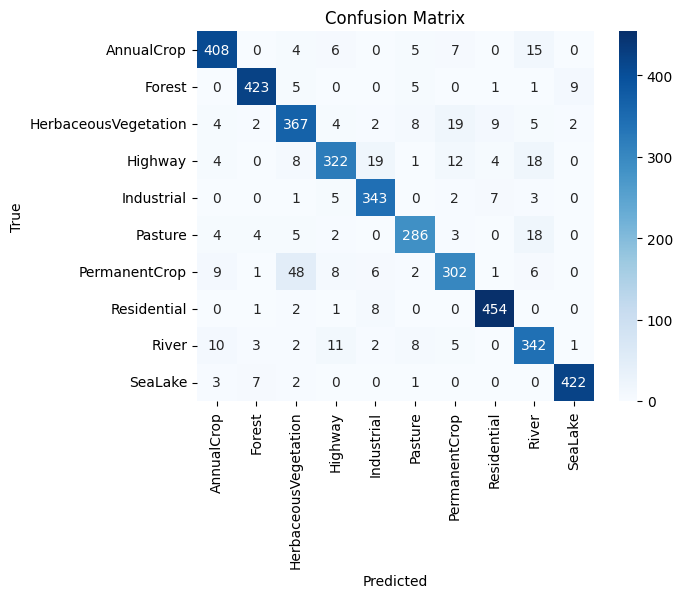

In [5]:
# Final Test Evaluation
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')
wandb.log({"Test Accuracy": test_accuracy})

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [7]:
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_loss': avg_train_loss,
    'val_loss': avg_val_loss,
    'val_accuracy': val_accuracy
}, 'checkpoint.pth')


In [8]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = checkpoint['epoch']


In [9]:
# Load the checkpoint
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
start_epoch = checkpoint['epoch']

# Training Loop with Validation
num_additional_epochs = 10  # Number of epochs you want to continue training
total_epochs = start_epoch + num_additional_epochs  # Total epochs after continuing

for epoch in range(start_epoch, total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for training
    train_progress = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}", unit="batch")
    
    for images, labels in train_progress:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        train_progress.set_postfix({
            "Train Loss": running_loss / len(train_loader),
            "Accuracy": 100 * correct / total
        })

    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Log metrics to Weights & Biases
    wandb.log({
        "Epoch": epoch+1,
        "Train Loss": avg_train_loss,
        "Train Accuracy": 100 * correct / total,
        "Validation Loss": avg_val_loss,
        "Validation Accuracy": val_accuracy
    })

    # Save the model checkpoint after each epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'val_accuracy': val_accuracy
    }, 'checkpoint.pth')


Epoch 11/20: 100%|██████████| 591/591 [07:52<00:00,  1.25batch/s, Train Loss=0.219, Accuracy=92.2] 


Epoch 11, Train Loss: 0.2191, Val Loss: 0.2731, Val Accuracy: 90.89%


Epoch 12/20: 100%|██████████| 591/591 [07:50<00:00,  1.26batch/s, Train Loss=0.206, Accuracy=92.9] 


Epoch 12, Train Loss: 0.2063, Val Loss: 0.2673, Val Accuracy: 91.09%


Epoch 13/20: 100%|██████████| 591/591 [07:50<00:00,  1.26batch/s, Train Loss=0.194, Accuracy=93]   


Epoch 13, Train Loss: 0.1943, Val Loss: 0.2649, Val Accuracy: 91.48%


Epoch 14/20: 100%|██████████| 591/591 [07:50<00:00,  1.26batch/s, Train Loss=0.19, Accuracy=93.4]  


Epoch 14, Train Loss: 0.1897, Val Loss: 0.2504, Val Accuracy: 91.41%


Epoch 15/20: 100%|██████████| 591/591 [07:51<00:00,  1.25batch/s, Train Loss=0.162, Accuracy=94.4] 


Epoch 15, Train Loss: 0.1623, Val Loss: 0.2291, Val Accuracy: 92.30%


Epoch 16/20: 100%|██████████| 591/591 [07:54<00:00,  1.25batch/s, Train Loss=0.153, Accuracy=94.6] 


Epoch 16, Train Loss: 0.1529, Val Loss: 0.2375, Val Accuracy: 92.02%


Epoch 17/20: 100%|██████████| 591/591 [07:54<00:00,  1.24batch/s, Train Loss=0.146, Accuracy=95]   


Epoch 17, Train Loss: 0.1463, Val Loss: 0.2361, Val Accuracy: 92.27%


Epoch 18/20: 100%|██████████| 591/591 [08:30<00:00,  1.16batch/s, Train Loss=0.147, Accuracy=94.7] 


Epoch 18, Train Loss: 0.1469, Val Loss: 0.2142, Val Accuracy: 92.91%


Epoch 19/20: 100%|██████████| 591/591 [08:46<00:00,  1.12batch/s, Train Loss=0.144, Accuracy=94.8] 


Epoch 19, Train Loss: 0.1444, Val Loss: 0.2266, Val Accuracy: 92.40%


Epoch 20/20: 100%|██████████| 591/591 [08:37<00:00,  1.14batch/s, Train Loss=0.145, Accuracy=95]   


Epoch 20, Train Loss: 0.1451, Val Loss: 0.2374, Val Accuracy: 92.22%


Test Accuracy: 92.32%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       445
           1       0.97      0.96      0.97       444
           2       0.88      0.88      0.88       422
           3       0.89      0.87      0.88       388
           4       0.90      0.93      0.92       361
           5       0.91      0.92      0.91       322
           6       0.88      0.85      0.87       383
           7       0.97      0.97      0.97       466
           8       0.89      0.90      0.89       384
           9       0.98      0.98      0.98       435

    accuracy                           0.92      4050
   macro avg       0.92      0.92      0.92      4050
weighted avg       0.92      0.92      0.92      4050



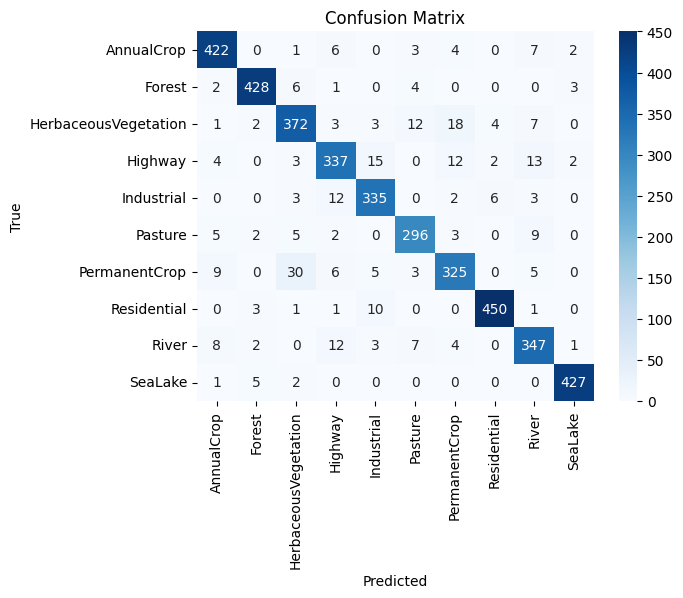

In [10]:
# Final Test Evaluation
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')
wandb.log({"Test Accuracy": test_accuracy})

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()